In [1]:
import tvb.simulator.models
import tvb.simulator.integrators

import matplotlib.pyplot as plt
import numpy as np
import arviz as az
import pymc3 as pm
import scipy
import theano.tensor as tt
import theano
import math
import pickle
from tqdm import tqdm

%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
# Simulation parameters
with open('limit-cycle_simulation.pkl', 'rb') as f:
    simulation_params = pickle.load(f)

In [3]:
# Model
oscillator_model = getattr(tvb.simulator.models, simulation_params["model"])(
    a=np.asarray([simulation_params["a_sim"]]),
    b=np.asarray([simulation_params["b_sim"]]),
    c=np.asarray([simulation_params["c_sim"]]),
    d=np.asarray([simulation_params["d_sim"]]),
    I=np.asarray([simulation_params["I_sim"]]),
)
oscillator_model.configure()

# Integrator
integrator = getattr(tvb.simulator.integrators, simulation_params["integrator"])(dt=simulation_params["dt"])
integrator.noise.nsig = np.array([simulation_params["nsig"]])
integrator.noise.configure()
integrator.noise.configure_white(dt=integrator.dt)
integrator.set_random_state(random_state=None)
integrator.configure()
integrator.configure_boundaries(oscillator_model)

In [4]:
X = simulation_params["simulation"]

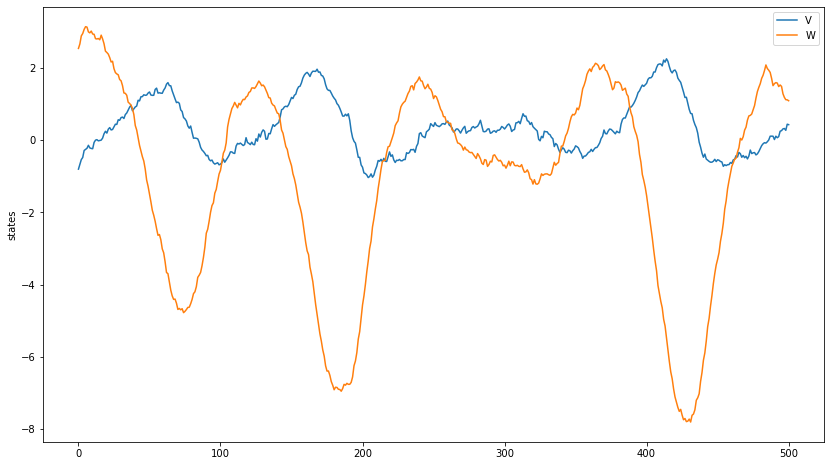

In [5]:
f1 = plt.figure(figsize=(14,8))
plt.plot(X[:, 0, 0, 0], label="V")
plt.plot(X[:, 1, 0, 0], label="W")
plt.ylabel("states")
plt.legend()
plt.show()

In [6]:
# global inference parameters
shape = X.shape
draws = 500
tune = 500
num_cores = 2

### Inference using non-centered model

In [7]:
from tvb.contrib.inversion.pymcInference import NonCenteredModel

In [8]:
ncModel = NonCenteredModel(oscillator_model)

In [9]:
ncModel.load("2022-08-31_1722_instance.pkl")

In [ ]:
#i = 4
#ncModel.pymc_model.unobserved_RVs[i].name

In [ ]:
#with ncModel.pymc_model:
#    print(ncModel.pymc_model.unobserved_RVs[i])

In [ ]:
with ncModel.pymc_model:
    a_star = pm.Normal("a_star", mu=0.0, sd=1.0)
    a = pm.Deterministic("a", var=2.0 + 0.01 * a_star)
    
    #b_star = pm.Normal("b_star", mu=0.0, sd=1.0)
    #b = pm.Deterministic("b", -10.0 + 0.1 * b_star)
    
    #c_star = pm.Normal("c_star", mu=0.0, sd=1.0)
    #c = pm.Deterministic("c", 0.0 + 0.01 * c_star)
    
    #d_star = pm.Normal("d_star", mu=0.0, sd=1.0)
    #d = pm.Deterministic("d", 0.02 + 0.001 * d_star)
    
    #I_star = pm.Normal("I_star", mu=0.0, sd=1.0)
    #I = pm.Deterministic("I", 0.0 + 0.01 * I_star)
    
    # Passing the prior distributions as dictionary. Also including fixed model parameters.
    priors = {
        "a": a,
        "b": np.array([simulation_params["b_sim"]]),
        "c": np.array([simulation_params["c_sim"]]),
        "d": np.array([simulation_params["d_sim"]]),
        "I": np.array([simulation_params["I_sim"]]),
        "tau": np.array([1.0]),
        "e": np.array([3.0]),
        "f": np.array([1.0]),
        "g": np.array([0.0]),
        "alpha": np.array([1.0]),
        "beta": np.array([1.0]),
        "gamma": np.array([1.0])
    }
    
    consts = {
        "coupling": np.zeros([2, 1, 1]), 
        "local_coupling": 0.0
    }
    
    x_init = theano.shared(X[0], name="x_init")
    
    BoundedNormal = pm.Bound(pm.Normal, lower=0.0)
    
    # sd should be in the range of sqrt(2*nsig)
    noise_star = BoundedNormal(name="noise_star", mu=0.0, sd=1.0)
    noise = pm.Deterministic(name="noise", var=0.05 + 0.1 * noise_star)
    
    x_t_star = pm.Normal(name="x_t_star", mu=0.0, sd=1.0, shape=tuple(shape))
    x_t = pm.Deterministic(name="x_t", var=noise * x_t_star)
    
    amplitude_star = pm.Normal("amplitude_star", mu=0.0, sd=1.0)
    amplitude = pm.Deterministic("amplitude", 0.0 + amplitude_star)
    
    offset_star = pm.Normal("offset_star", mu=0.0, sd=1.0)
    offset = pm.Deterministic("offset", 0.0 + offset_star)
    
    epsilon = BoundedNormal("epsilon", mu=0.0, sd=1.0)

In [ ]:
ncModel.set_model(
    priors=priors, 
    consts=consts, 
    obs=X, 
    time_step=dt,
    x_init=x_init,
    time_series=x_t,
    amplitude=amplitude,
    offset=offset,
    obs_noise=epsilon
)

In [13]:
nc_data = ncModel.inference_data

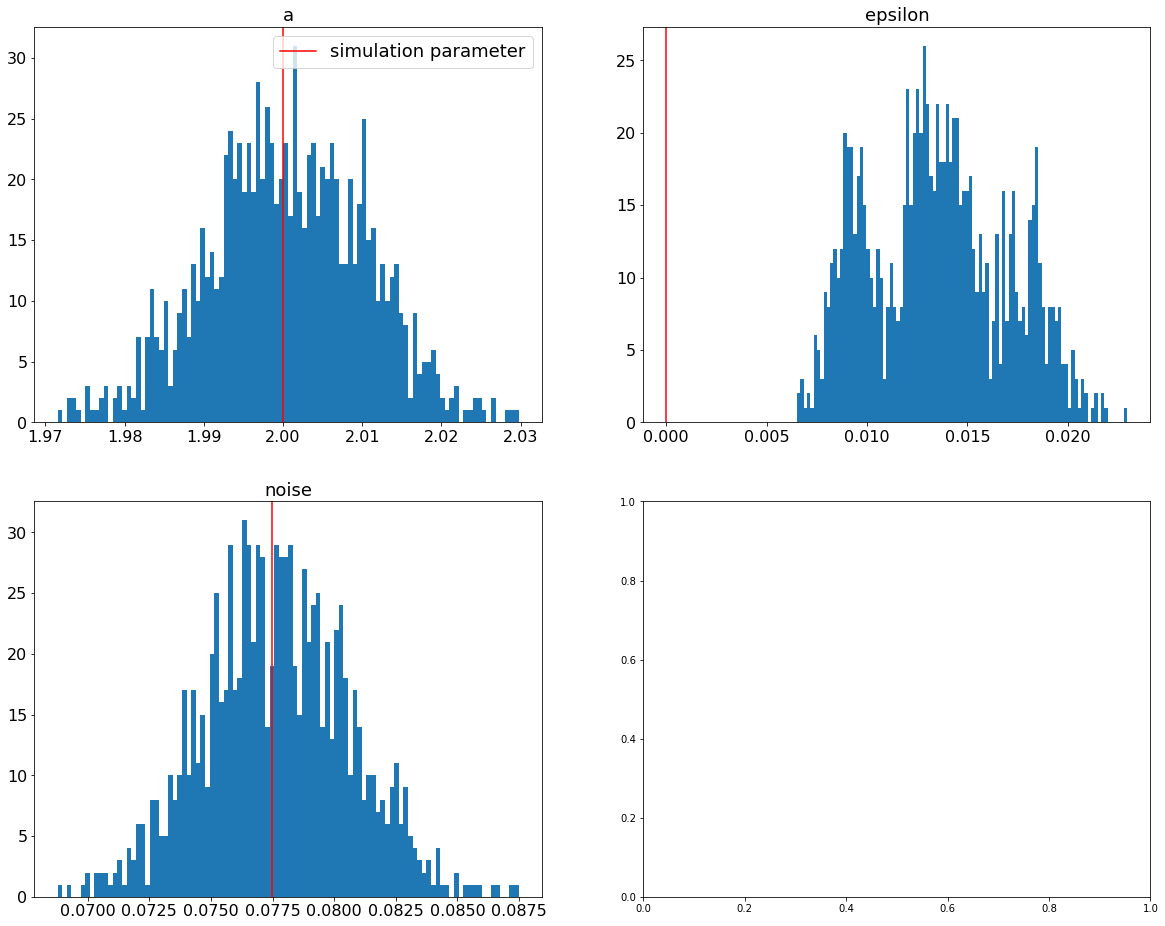

In [14]:
ncModel.plot_posterior_samples(
    init_params={"a": simulation_params["a_sim"], 
                 "epsilon": 0.0, 
                 "noise": np.sqrt(2 * simulation_params["nsig"])
                }
)

In [15]:
posterior_x_obs = nc_data.posterior_predictive.x_obs.values.reshape((num_cores * draws, *shape))

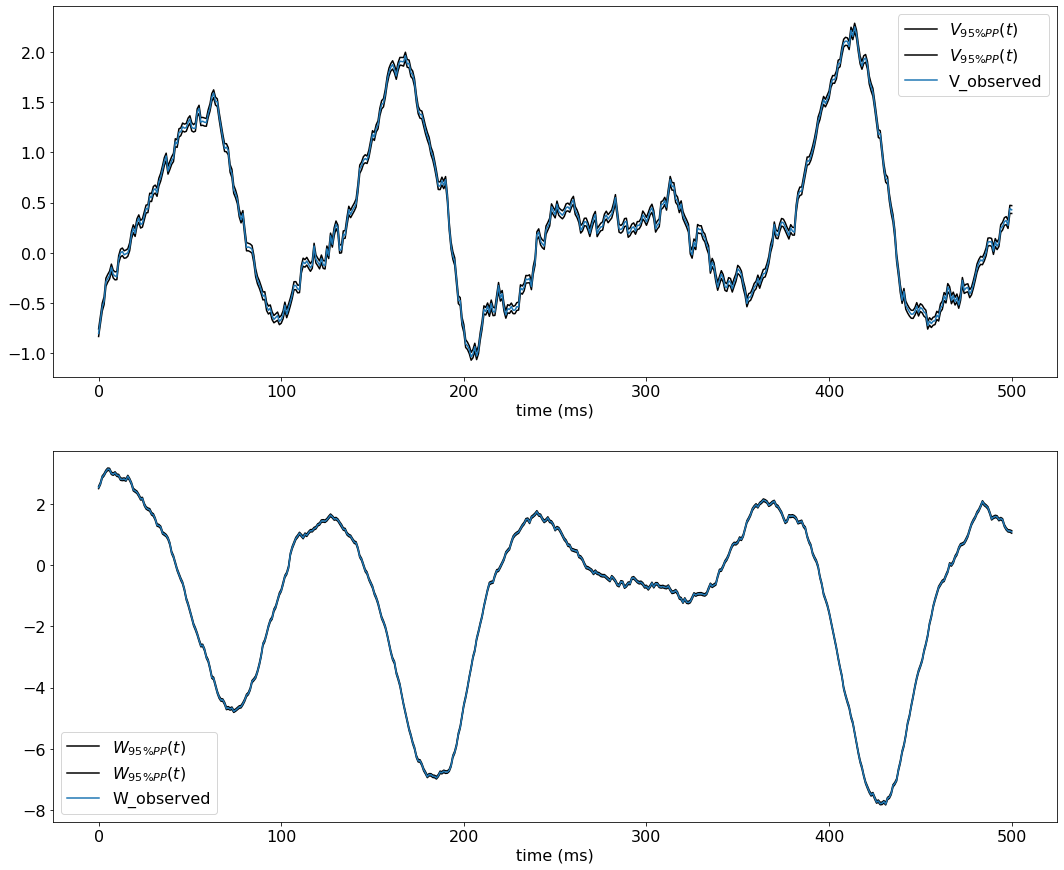

In [16]:
f3, axes3 = plt.subplots(nrows=2, ncols=1, figsize=(18,15))
axes3[0].plot(np.percentile(posterior_x_obs[:, :, 0, 0, 0], [2.5, 97.5], axis=0).T, 
              "k", label=r"$V_{95\% PP}(t)$")
axes3[0].plot(X[:, 0, 0, 0], label="V_observed")
#axes3[0].plot(posterior_x_obs[0, :, 0, 0, 0])
axes3[0].legend(fontsize=16)
axes3[0].set_xlabel("time (ms)", fontsize=16)
axes3[0].tick_params(axis="both", labelsize=16)

axes3[1].plot(np.percentile(posterior_x_obs[:, :, 1, 0, 0], [2.5, 97.5], axis=0).T, 
         "k", label=r"$W_{95\% PP}(t)$")
axes3[1].plot(X[:, 1, 0, 0], label="W_observed")
#axes3[1].plot(posterior_x_obs[0, :, 1, 0, 0])
axes3[1].legend(fontsize=16)
axes3[1].set_xlabel("time (ms)", fontsize=16)
axes3[1].tick_params(axis="both", labelsize=16)

plt.show()

In [17]:
criteria = ncModel.model_criteria(["WAIC", "LOO"])

/Users/erichter/opt/anaconda3/envs/BrainSim-env/lib/python3.9/site-packages/arviz/stats/stats.py:1661: UserWarning: For one or more samples the posterior variance of the log predictive densities exceeds 0.4. This could be indication of WAIC starting to fail. 
See http://arxiv.org/abs/1507.04544 for details
  warnings.warn(
/Users/erichter/opt/anaconda3/envs/BrainSim-env/lib/python3.9/site-packages/arviz/stats/stats.py:812: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(


In [18]:
print("WAIC: ", criteria["WAIC"])
print("LOO: ", criteria["LOO"])

WAIC:  2547.045370122635
LOO:  2343.6072040990057


In [19]:
ncModel.summary = az.summary(ncModel.inference_data)

In [20]:
ncModel.summary.loc[["epsilon", "noise"]]

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
epsilon,0.014,0.003,0.008,0.020,0.002,0.002,3.0,12.0,1.81
noise,0.078,0.003,0.072,0.083,0.001,0.000,26.0,109.0,1.07


In [21]:
x_hat_indezes = [index for index in ncModel.summary.index if "x_hat" in index]
x_rhat_mean = ncModel.summary.loc[x_hat_indezes]["r_hat"].mean()
print("Mean r_hat value for time series:", x_rhat_mean)
x_rhat_sd = ncModel.summary.loc[x_hat_indezes]["r_hat"].std()
print("SD r_hat value for time series:", x_rhat_sd)

Mean r_hat value for time series: 1.0332035928143712
SD r_hat value for time series: 0.010578495285406385


In [22]:
divergent = ncModel.inference_data.sample_stats.diverging.values.reshape(-1)
print("Number of Divergent %d" % divergent.nonzero()[0].size)
divperc = divergent.nonzero()[0].size / len(divergent) * 100
print("Percentage of Divergent %.1f" % divperc)
print("Mean tree accept %.1f" % ncModel.inference_data.sample_stats.acceptance_rate.values.mean())

Number of Divergent 3
Percentage of Divergent 0.3
Mean tree accept 0.9
